# Automatically Asign Signs on a Tabular Papyrus to Rows

As a prehistory: The photo of the middle part of the [Demotic astronomical papyrus Pap. Berlin P 8279+23547](https://id.smb.museum/object/823520/griechisch-demotischer-papyrus-mit-getreideabrechnungen-und-sterntafeln-pap--berlin-p-8279---p-23547). This photo comprises the parts E-F on the verso of the papyrus and has been downloaded from [https://id.smb.museum/object/823520](https://recherche.smb.museum/images/69/6935950_4000x4000.jpg) and stored as [P_08279_V_002.jpg](./photos/P_08279_V_002.jpg). The corners of the photo have been marked with 21 x 21 px squares, to be able to anchor the outline of the papyrus, the signs and the boundaries relative to each other. This manipulated photo has been saved as [P_08279_V_002.jpg](./photos/P_08279_V_002.png). With the help of Inkscape the manupulated photo has been converted into a svg vector graphic. The result of this 1st step is: [P_08279_V_002_step01.svg](./svgs/P_08279_V_002_step01.svg) This svg has been cleaned up. The result of this 2nd step is: [P_08279_V_002_step02.svg](./svgs/P_08279_V_002_step02.svg) Finally, the columns have been marked on it manually. The result of this 3rd step is: [P_08279_V_002_step03.svg](./svgs/P_08279_V_002_step03.svg) In the next step the infomation which sign belongs into which column has been written into the svg. The [penulitmate notebook](./1_AsignSigns2Columns.ipynb) asigned the path of the signs the column there are in, resulting in [P_08279_V_002_step04.svg](./svgs/P_08279_V_002_step04.svg). The [previous notebook](./2_GroupPath2Signs.ipynb) merged close neighboring signs into one path, resulting in [P_08279_V_002_step05.svg](./svgs/P_08279_V_002_step05.svg). This notebook here will now automatically asign the signs per column to the row there are in.

## Preample

### Use the full width of the screen available

In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

### Import necessary packages

configparser is used to easily read in the [configuration file](./config.properties). distinctipy is used to generate visually distinct colors for displaying the results with matplotlib later. As svgs are based on xml, bs4 is used to manipulate the svg. matplotlib is a library to display graphs, it is used here for draw the color coded shapes of the signs, display and save these graphs for manual inspections of the results. svgpath2mpl is used to handle the svgs while shapely turns the paths from the svgs into polygons so that they can be handled in a more efficient way in Python. numpy turns the polygons into numerical data usable by sklearn, which in turn is used to actually carry out the clustering of the data, aka the automatical asignment of the of the signs to certain rows. For reproducibility it is necessary to make the results of the clustering deterministic. The desire for deterministic results is also the reason why parallelisation is turned of as it might still introduce indeterministic behaviour despite the random state being set within the clustering algorithm. The parallelization has to be disabled before importing the sklearn package, consequently it is put at the top of the imported packages.

In [2]:
# disabling parallelization
import os
os.environ["OMP_NUM_THREADS"] = "1"

import configparser
import distinctipy as dpy
from bs4 import BeautifulSoup as bs
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from svgpath2mpl import parse_path
from shapely.geometry import Polygon
import shapely
import numpy as np
from sklearn.cluster import *

### Read the config file

When reading in the config the comments are ignored as well as any capitalization. The config is split into a general part and a one that is specific for each papyrus photo that is worked on. In the following the general config `configGen` may be accessed by `configGen[field]`.

In [3]:
config = configparser.RawConfigParser()
config.read('./config.properties')

configGen = dict(config.items('general'))
configPap = dict(config.items(configGen['workpap']))

## Main Part

### Open the svg and process it with bs4

Read the file to work on and the number of the step from the configs above.

In [4]:
numStep = int(configPap['numstep'])
filename = configPap['filename'] + '_step' + str(numStep + 2).zfill(2) + '.svg'

Here the svg is opened and (as svg is based on xml) processed with bs4. All used column labels are extracted and stored in the variable `col`.

In [5]:
with open(configGen['svgdir'] + filename, 'r') as f:
    file = f.read() 
soup = bs(file, 'xml')

In [6]:
col = []
for element in soup.find_all('path', style=lambda x: 'stroke:#ff0000' in x):
    col.append(element.get('inkscape:label'))

Unfortunately, so far how many and which rows are contained in each column still needs to be determined manually. This information has been stored in the [configuration file](./config.properties) in the property `rows`.

In [7]:
rows = eval(configPap['rows'])

This function graps all paths from the svg transform them into a dictionary of the form `{'id': 'path'}`. These are then stored yet again in a dictionary with the column the path is in as a key. So the final dictionary has the following form: `signs = {'colI': {'id1': 'path1', 'id2': 'path2', ...}, 'colII': ...}`. This makes the paths easier to handle in Python.

In [8]:
signs = {}
for c in col:
    signs[c] = {}
    for element in soup.find_all(attrs={"column": c}):
        signs[c][element.get('id')] = element.get('d')

### Apply KI methods to cluster signs

The following cell calculates the mean, minimal, maximal and geometrical mean y-value for each path in each column. 
Some other location parameter have been tested as features too: 
- All y-values from a path (padded with zeros to make them fit the format of the fit input) -> no reasonable clusters obtained as the vertices of a svg path are not comparable among different paths and therefore not usable as features at all
- mean, minimal and maximal x- and y-values -> no reasonable clusters in this context as for the rows only a horizontal clustering is needed
- mean, minimal and maximal y-value -> fairly usable cluster obtained, however, the labels obtained with mean, minimal, maximal and geometrical mean y-value as features are more accurate
- mean and geometrical mean y-value -> fairly usable cluster obtained, however, the labels obtained with mean, minimal, maximal and geometrical mean y-value as features are more accurate
- mean, minimal, maximal, geometrical mean and harmonical mean y-value -> fairly usable cluster obtained, however, the labels obtained with mean, minimal, maximal and geometrical mean y-value as features are more accurate

In [9]:
yMean = {}
yMin = {}
yMax = {}
yGMean = {}
for c in col:
    yMean[c] = {}
    yMin[c] = {}
    yMax[c] = {}
    yGMean[c] = {}
    for s in signs[c].keys():
        Y = np.concatenate(parse_path(signs[c][s]).to_polygons(), axis = 0).T[1]
        yMean[c][s] = Y.mean()
        yMin[c][s] = Y.min()
        yMax[c][s] = Y.max()
        yGMean[c][s] = np.exp(np.log(Y).mean())

The most common approach to extract rows from text is to use mainly dilation from OpenCV library, which might work fine for computer or typewritter produced tables with bordered cells. However the rows on most papyri are neither bordered and always handwritten; meaning the rows are not necessarily straight. I tried to apply methods from the OpenCV library to papyri, without success. The standard algorithms in Computer Vision employ neural networks. However, their downside is that they need a lot of labeled data available for training. This data is not available in this case. As will be shown below the k-means algorithm works pretty well on clustering signs into the respective row they are in. The mean, minimal, maximal and geometrical mean y value for each path in each column are used as features for the k-means algorithm below. As we already extracted the columns and are only interested in the rows here, it is important to only used the y values of the paths here, as we are aiming for a horizontal clustering of the paths. As the rows which do contain (at least traces of) signs on the papyrus has been (manually) predetermined, also the number of clusters for each column is known from the number of rows containing (at least traces of) signs. For reproducibility it is necessary to insert a random state to make the results of the clustering deterministic. 

In [10]:
# Features: Y mean, Y minimal, Y maximal, Y geometric mean
label = {}
for c in col:
    label[c] = KMeans(n_clusters=len(rows[c]), random_state=42, n_init = 'auto').fit(np.array([np.array([yMean[c][s], yMin[c][s], yMax[c][s], yGMean[c][s]]) for s in list(signs[c].keys())]))

Here the calculated labels are extracted from result of the fitting above.

In [11]:
signLabels = {}
for c in col:
    signLabels[c] = {}
    for i in range(len(list(signs[c].keys()))):
        signLabels[c][list(signs[c].keys())[i]] = label[c].labels_[i]

The following two cells match the labels produced by k-means with the rows actually containing (at least traces of) signs.

In [12]:
orderedRows = {}
for c in col:
    orderedRows[c] = {}
    for i in sorted(list(set(signLabels[c].values()))):
        orderedRows[c][i] = None
        for s in list(signs[c].keys()):
            if signLabels[c][s] == i and not orderedRows[c][i]:
                orderedRows[c][i] = yMean[c][s]
    keys = list(orderedRows[c].keys())
    valuesIndexSorted = list(np.argsort(np.array(list(orderedRows[c].values()))))
    orderedRows[c] = {valuesIndexSorted[i]: keys[i] for i in range(len(keys))}

In [13]:
signLabelsOrdered = {}
for c in col:
    signLabelsOrdered[c] = {}
    for i in signLabels[c].keys():
        signLabelsOrdered[c][i] = rows[c][orderedRows[c][signLabels[c][i]]]

### Define visually distinct colors

The highest row number still bearing (traces of) signs is calculated first given the infomation from the configuration file. Afterwards, just as many visually most distinct colors are calculated. They will be used later to display the results of the automatic asignment of rows to the signs.

In [14]:
maxrows = max(map(max, eval(configPap['rows']).values()))
colors = {i + 1: dpy.get_colors(maxrows, rng = 42)[i] for i in range(maxrows)}

### Display preliminary results

The following cell displayes all signs colorcoded according to row number asigned to them by the k-means algorithm. A legend connecting the color and the row it symbolizes is displayed next to each column. Unfortunately the order of the columns is inverted, meaning the rightmost column on the papyrus is displayed on the far left here. So far I have not find a way to fix this. As the displayed graphic in this notebook is small, the graphic is also exported as a jpg file into the folder [controlgraphs](./controlgraphs/)  with the expression `rowsPreCorrecting` in the filename. This graphic has to be inspected carefully to check for any mislabeled signs which are corrected below.

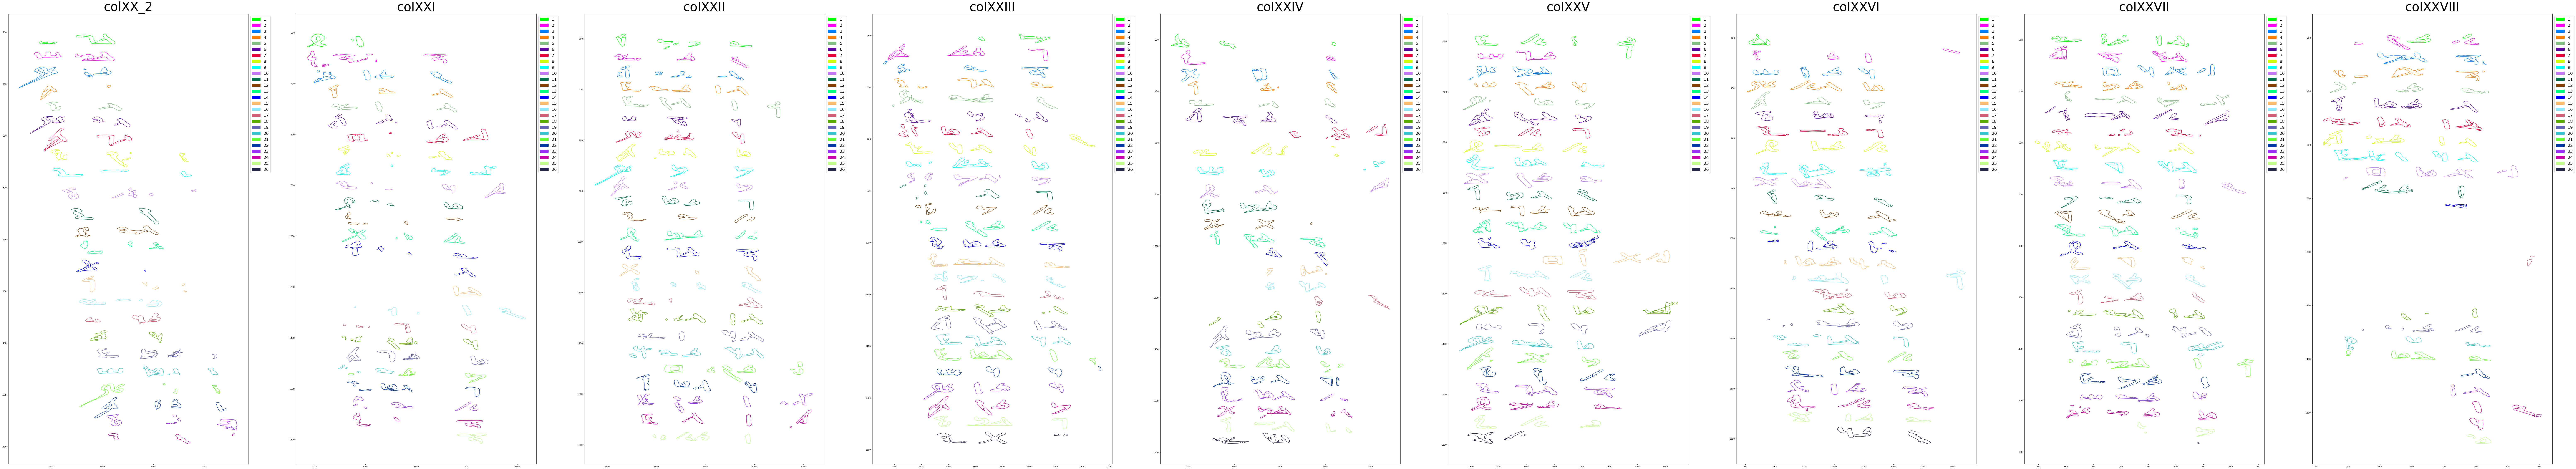

In [15]:
plt.figure(figsize = (55*4, 10*4))
legend = []
for c in colors.keys():
    legend.append(mpatches.Patch(color=colors[c], label=c))
for i in list(range(len(col))):
    plt.subplot(1, len(col), i + 1)
    plt.gca().invert_yaxis()
    for s in list(signs[col[i]].keys()):
        plt.plot(*np.concatenate(parse_path(signs[col[i]][s]).to_polygons(), axis = 0).T, label = signLabels[col[i]][s], c = colors[signLabelsOrdered[col[i]][s]])
    plt.title(col[i], fontsize = 60)
    plt.legend(bbox_to_anchor=(1, 1), loc='upper left', fontsize = 20, handles=legend)
plt.savefig(configGen['controlgraphsdir'] + configPap['filename'] + '_rowsPreCorrecting_step' + str(numStep + 2).zfill(2) + '.jpg')

### Manually correct mislabeled paths

In the following the labels of mislabeled paths are manually corrected. There are isolated mislabeled paths for which the correct label is asigned in a dictionary structure and there are instances where either two labels are used on one row or two rows of signs got the same label. These last two cases are corrected either by increasing or decreasing the affected labels by 1 all at once. Even though the manual correction in this case is done quickly, it is a step that comes in very unhandy if you are processing more papyri. One step to cut down necessary corrections was to merge close neighboring paths into one path, which had been done in the [previous notebook](./2_GroupPath2Signs.ipynb). It might be possible to improve the performance of the k-means algorithm by finding better features or to try out other clustering algorithms.

In [16]:
rowSigns = eval(configPap['rows'])
if configPap['filename'] == 'P_08279_V_002':
    mislabeledSigns = {'colXXVIII': {'path29913': 9,
                                     'path28029': 24},
                       'colXXVII': {'path30407': 5},
                       'colXXVI': {'path30857': 1},
                       'colXXV': {'path29283': 14},
                      'colXXIII': {'path30777': 2,
                                   'path29797': 10,
                                   'path28377': 21},
                       'colXXI': {'path29081': 15,
                                  'path15229': 20}}
    # Correcting colXXI:
    for s in list(signLabelsOrdered['colXXI'].keys()):
        if signLabelsOrdered['colXXI'][s] >= 15 and signLabelsOrdered['colXXI'][s] <= 20:
            signLabelsOrdered['colXXI'][s] = signLabelsOrdered['colXXI'][s] + 1
    # Correcting colXXVIII:
    for s in list(signLabelsOrdered['colXXVIII'].keys()):
        if (signLabelsOrdered['colXXVIII'][s] >= 2 and signLabelsOrdered['colXXVIII'][s] <= 24):
            signLabelsOrdered['colXXVIII'][s] = rowSigns['colXXVIII'][rowSigns['colXXVIII'].index(signLabelsOrdered['colXXVIII'][s]) - 1]

This cell applies the individual corrections to the original labels and overwrites the old wrong labels.

In [17]:
for c in list(mislabeledSigns.keys()):
    for s in list(mislabeledSigns[c].keys()):
        signLabelsOrdered[c][s] = mislabeledSigns[c][s]

### Display corrected result

To double check if all wrong labels are corrected, the following grahic displayes all signs colorcoded according to row there in after the wrong labels have been corrected. As above a legend connecting the color and the row it symbolizes is displayed next to each column. Unfortunately the order of the columns is also here inverted, meaning the rightmost column on the papyrus is displayed on the far left here. So far I have not find a way to fix this. As the displayed graphic in this notebook is small, the graphic is also exported as a jpg file into the folder [controlgraphs](./controlgraphs/) with the expression `rowsAfterCorrecting` in the filename to distinguish it from the previous graphic displaying the uncorrected labels.

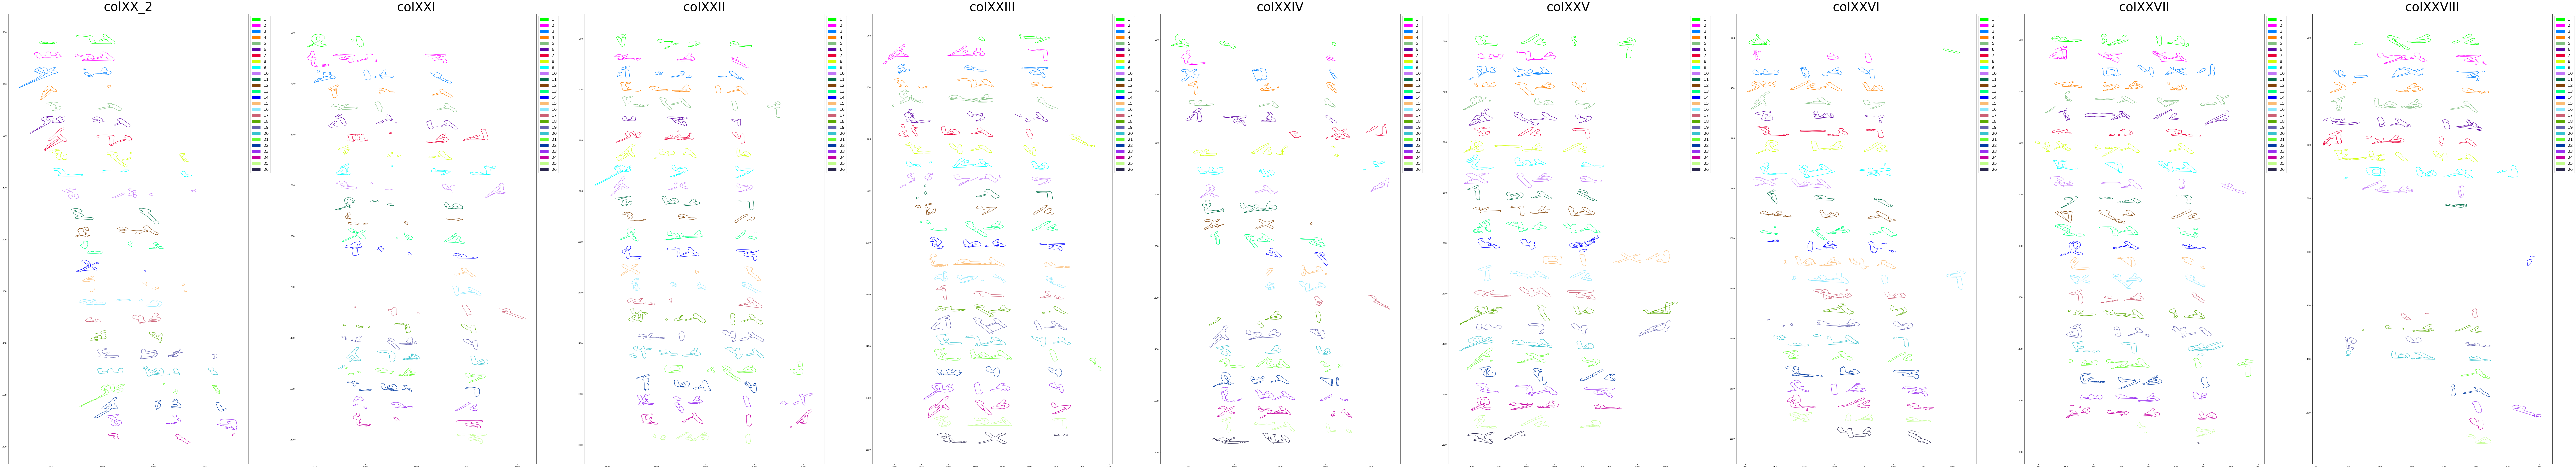

In [18]:
plt.figure(figsize = (55*4, 10*4))
legend = []
for c in colors.keys():
    legend.append(mpatches.Patch(color=colors[c], label=c))
for i in range(len(col)):
    plt.subplot(1, len(col), i + 1)
    plt.gca().invert_yaxis()
    for s in list(signs[col[i]].keys()):
        plt.plot(*np.concatenate(parse_path(signs[col[i]][s]).to_polygons(), axis = 0).T, label = signLabelsOrdered[col[i]][s], c = colors[signLabelsOrdered[col[i]][s]])
    plt.title(col[i], fontsize = 60)
    plt.legend(bbox_to_anchor=(1, 1), loc='upper left', fontsize = 20, handles=legend)
plt.savefig(configGen['controlgraphsdir'] + configPap['filename'] + '_rowsAfterCorrecting_step' + str(numStep + 2).zfill(2) + '.jpg')

### Add row labels to the svg

The following cell adds the row that each sign is in as an attribute `row` to each sign path in the svg.

In [19]:
for c in col:
    for s in list(signLabelsOrdered[c].keys()):
        soup.find(attrs={'id' : s})['row'] = signLabelsOrdered[c][s]

## End

### Export the modified svg

Finally, the modified svg is exported under the original directory and filename but the step number is increased by one to avoid overwriting the svg imported above.

In [20]:
with open('./svgs/' + filename.replace('_step' + str(numStep + 2).zfill(2), '_step' + str(numStep + 3).zfill(2)), 'w') as f:
    f.write(soup.prettify())